# Load modules and data

In [1]:
import numpy as np
import pandas as pd
import os
import random
import warnings
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
# Set the current directory
os.chdir(os.getcwd())

In [3]:
# Load the data
df = pd.read_excel('svm_data.xlsx', index_col = 0)

df.head()

,class,exn_roi,rsn1,rsn2,rsn3,rsn4,rsn5,rsn6,rsn7,rsn8,rsn9,rsn10
C01_mr01,0,28.686549,6.668095,7.062945,9.191991,5.824103,9.984949,8.548477,2.166434,8.153751,5.886930,4.034545
C02_mr01,0,23.345770,15.598857,5.401197,7.600642,17.334917,5.588446,23.833144,6.821207,12.080249,4.265804,3.632805
C03_mr01,0,12.863962,13.148390,8.893713,9.726090,12.696923,7.317480,4.920460,3.317336,6.725749,12.638017,10.584244
C04_mr01,0,4.877827,6.393418,8.766292,9.912276,13.558147,3.320773,2.559796,1.874109,2.654851,2.970516,2.763736
C06_mr01,0,9.916884,14.032633,9.159434,5.567815,12.826694,7.987360,12.122178,20.232326,5.031461,8.602431,10.389680


In [4]:
# Extract labels (y vector) and rsn data
y = np.array(df['class'])        

exn_roi = np.array(df['exn_roi']).reshape(-1, 1)
rsn1 = np.array(df['rsn1']).reshape(-1, 1)
rsn2 = np.array(df['rsn2']).reshape(-1, 1)
rsn3 = np.array(df['rsn3']).reshape(-1, 1)
rsn4 = np.array(df['rsn4']).reshape(-1, 1)
rsn5 = np.array(df['rsn5']).reshape(-1, 1)
rsn6 = np.array(df['rsn6']).reshape(-1, 1)
rsn7 = np.array(df['rsn7']).reshape(-1, 1)
rsn8 = np.array(df['rsn8']).reshape(-1, 1)
rsn9 = np.array(df['rsn9']).reshape(-1, 1)
rsn10 = np.array(df['rsn10']).reshape(-1, 1)

# Support Vector Machine

In [5]:
# Load the SVM
clf = svm.SVC(kernel = 'linear', C = 1, probability = True)

In [6]:
# Create list of rsns as well as names of each network as strings
rsn_list = [exn_roi, rsn1, rsn2, rsn3, rsn4, rsn5, rsn6, rsn7, rsn8, rsn9, rsn10]

rsn_strings = ['exn_roi','rsn1', 'rsn2', 'rsn3', 'rsn4', 'rsn5', 'rsn6', 'rsn7', 'rsn8', 'rsn9', 'rsn10']

In [7]:
# Loop through each RSN
for i in range(len(rsn_list)):
    # Access the nth list
    rsn = rsn_list[i]
    
    # Create a string which will be converted to a global dictionary variable to store results 
    results_string = rsn_strings[i] + '_results'
    
    # Initialize an empty dictionary to store results which will be renamed with the string above
    results_dict = {}
    
    # Create train/test splits for the list, looping through 10 iterations
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(rsn, y, random_state = j, test_size = 0.3, stratify = y)
        
        # Fit SVM to training data
        clf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Add a legend to the first entry
        results_dict['Key is the random state split'] = ['1st array is y_actual', '2nd is y_pred']
        
        # Add the predictions and actual values to results_dict, with each iteration serving as the key
        results_dict[j] = [y_test, y_pred]
        
        # Make the results dictionary a global variable
        globals()[results_string] = results_dict

In [8]:
# Calculate the sensitivity and specificity for each split for each network
# Create an empty dictioanry to store results
with warnings.catch_warnings(record=True):
    performance = {}

    # Loop through the lists
    for i in range(len(rsn_list)):
        # Set the string which we can access as a global variable
        results_string = rsn_strings[i] + '_results'
        results = globals()[results_string]
    
        # Create an empty list to store performance metrics
        sens_list = []
        spec_list = []
        acc_list = []
    
        # Access each data split and then save y_actual/pred
        for j in range(10):
            y_actual = results[j][0]
            y_pred = results[j][1]
        
            # Save a classification report as a dictionary
            report = classification_report(y_actual, y_pred, output_dict = True)
        
            # Access sensitivity (pos class recall), specificity (neg class recall), and accuracy
            sens = report['1']['recall']
            spec = report['0']['recall']
            acc = report['accuracy']
        
            # Append to corresponding list
            sens_list.append(sens)
            spec_list.append(spec)
            acc_list.append(acc)
        
        # Add the sens/spec/acc lists to the empty performance dictionary
        # First access the corresponding rsn name to save as a key
        rsn_sens = rsn_strings[i] + '_sens'
        rsn_spec = rsn_strings[i] + '_spec'
        rsn_acc = rsn_strings[i] + '_acc'
    
        # Add each of the performance lists to corresponding key
        performance[rsn_sens] = sens_list
        performance[rsn_spec] = spec_list
        performance[rsn_acc] = acc_list

# ROC Curve

In [9]:
# Loop through each RSN as above
for i in range(len(rsn_list)):
    # Access the nth list
    rsn = rsn_list[i]
    
    # Create a string which will be converted to a global dictionary variable to store results 
    results_string = rsn_strings[i] + '_roc_results'
    
    # Initialize an empty dictionary to store results which will be renamed with the string above
    results_dict = {}
    
    # Create train/test splits for the list, looping through 10 iterations
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(rsn, y, random_state = j, test_size = 0.3, stratify = y)
        
        # Fit SVM to training data
        clf.fit(X_train, y_train)
        
        # Calculate TEST and TRAINING probabilities - note we already have actual values (y_test and y_train)
        train_score = clf.predict_proba(X_train)[:, 1]
        test_score = clf.predict_proba(X_test)[:, 1]
        
        # Add a legend to the first entry
        results_dict['Key = split'] = ['1st array = y_train', '2nd = y_test', '3rd = train_score', '4th = test_score']
        
        # Add the predictions and actual values to results_dict, with each iteration serving as the key
        results_dict[j] = [y_train, y_test, train_score, test_score]
        
        # Make the results dictionary a global variable
        globals()[results_string] = results_dict

In [10]:
# We now want to loop through each dictionary of results and CONCATENATE the arrays to generate 
# an overall array of probabilities and actual values

# Loop through the lists
for i in range(len(rsn_list)):
    # Set the string which we can access as a global variable
    results_string = rsn_strings[i] + '_roc_results'
    roc_results = globals()[results_string]
    
    # Initialize empty lists to store results
    y_train_list = []
    y_test_list = []
    train_score_list = []
    test_score_list = []
    
    # Access each data split and then save y_train, y_test, train_score, test_score as variables
    for j in range(10):
        y_train = roc_results[j][0]
        y_test = roc_results[j][1]
        train_score = roc_results[j][2]
        test_score = roc_results[j][3]
        
        # Append to the results lists
        y_train_list.append(y_train)
        y_test_list.append(y_test)
        train_score_list.append(train_score)
        test_score_list.append(test_score)
        
    # Concatenate these lists
    y_train_ovr = np.concatenate([y_train_list[0], y_train_list[1], y_train_list[2], y_train_list[3], y_train_list[4], 
                                y_train_list[5], y_train_list[6], y_train_list[7], y_train_list[8], y_train_list[9]])
        
    y_test_ovr = np.concatenate([y_test_list[0], y_test_list[1], y_test_list[2], y_test_list[3], y_test_list[4], 
                                y_test_list[5], y_test_list[6], y_test_list[7], y_test_list[8], y_test_list[9]])
        
    train_score_ovr = np.concatenate([train_score_list[0], train_score_list[1], train_score_list[2], train_score_list[3], 
                                    train_score_list[4], train_score_list[5], train_score_list[6], train_score_list[7], 
                                    train_score_list[8], train_score_list[9]])
        
    test_score_ovr = np.concatenate([test_score_list[0], test_score_list[1], test_score_list[2], test_score_list[3], 
                                    test_score_list[4], test_score_list[5], test_score_list[6], test_score_list[7],
                                    test_score_list[8], test_score_list[9]])
    
    # Save these as variables
    network = rsn_strings[i]
    
    globals()[network + '_y_train'] = y_train_ovr
    globals()[network + '_y_test'] = y_test_ovr
    globals()[network + '_train_score'] = train_score_ovr
    globals()[network + '_test_score'] = test_score_ovr    

In [11]:
# We now need to calculate FPR, TPR, and AUC for each network

# Loop through the list of rsn names
for i in range(len(rsn_list)):
    network = rsn_strings[i]
    
    y_train = globals()[network + '_y_train']
    y_test = globals()[network + '_y_test']
    train_score = globals()[network + '_train_score']
    test_score = globals()[network + '_test_score']
    
    # For TRAINING data
    # Calculate FPR and TPR 
    fpr, tpr, thresholds = roc_curve(y_train, train_score, pos_label = 1)
    
    # Calculate AUC
    auc = roc_auc_score(y_train, train_score)
    auc_score = format(auc, '.2f')
    
    # Save as variables
    globals()[network + '_tpr_train'] = tpr
    globals()[network + '_fpr_train'] = fpr
    globals()[network + '_auc_train'] = auc_score
    
    # Repeat for TEST data
    # Calculate FPR and TPR 
    fpr, tpr, thresholds = roc_curve(y_test, test_score, pos_label = 1)
    
    # Calculate AUC
    auc = roc_auc_score(y_test, test_score)
    auc_score = format(auc, '.2f')
    
    # Save as variables
    globals()[network + '_tpr_test'] = tpr
    globals()[network + '_fpr_test'] = fpr
    globals()[network + '_auc_test'] = auc_score
    globals()[network + '_thresh_test'] = thresholds

# Graph results

### EXN ROI vs RSNs

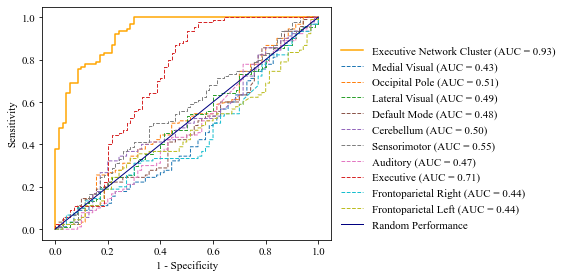

In [22]:
# Training ROC curve first
plt.rc('font', family = 'Times New Roman', size = 11)
fig, ax = plt.subplots()

# Plot each data set
ax.plot(exn_roi_fpr_train, exn_roi_tpr_train, color = 'orange', 
        label = 'Executive Network Cluster (AUC = {})'.format(exn_roi_auc_train))
ax.plot(rsn1_fpr_train, rsn1_tpr_train, lw = 1, linestyle = '--', color = 'tab:blue', 
        label = 'Medial Visual (AUC = {})'.format(rsn1_auc_train))
ax.plot(rsn2_fpr_train, rsn2_tpr_train, lw = 1, linestyle = '--', color = 'tab:orange', 
        label = 'Occipital Pole (AUC = {})'.format(rsn2_auc_train))
ax.plot(rsn3_fpr_train, rsn3_tpr_train, lw = 1, linestyle = '--', color = 'tab:green', 
        label = 'Lateral Visual (AUC = {})'.format(rsn3_auc_train))
ax.plot(rsn4_fpr_train, rsn4_tpr_train, lw = 1, linestyle = '--', color = 'tab:brown', 
        label = 'Default Mode (AUC = {})'.format(rsn4_auc_train))
ax.plot(rsn5_fpr_train, rsn5_tpr_train, lw = 1, linestyle = '--', color = 'tab:purple', 
        label = 'Cerebellum (AUC = {})'.format(rsn5_auc_train))
ax.plot(rsn6_fpr_train, rsn6_tpr_train, lw = 1, linestyle = '--', color = 'tab:gray', 
        label = 'Sensorimotor (AUC = {})'.format(rsn6_auc_train))
ax.plot(rsn7_fpr_train, rsn7_tpr_train, lw = 1, linestyle = '--', color = 'tab:pink', 
        label = 'Auditory (AUC = {})'.format(rsn7_auc_train))
ax.plot(rsn8_fpr_train, rsn8_tpr_train, lw = 1, linestyle = '--', color = 'tab:red', 
        label = 'Executive (AUC = {})'.format(rsn8_auc_train))
ax.plot(rsn9_fpr_train, rsn9_tpr_train, lw = 1, linestyle = '--', color = 'tab:cyan', 
        label = 'Frontoparietal Right (AUC = {})'.format(rsn9_auc_train))
ax.plot(rsn10_fpr_train, rsn10_tpr_train, lw = 1, linestyle = '--', color = 'tab:olive', 
        label = 'Frontoparietal Left (AUC = {})'.format(rsn10_auc_train))

# Add random performance graph, legend, and axis titles
ax.plot([0, 1], [0, 1], color = 'navy', lw = 1, label = 'Random Performance')
ax.legend(loc = 'lower left', frameon = False, bbox_to_anchor=(1, 0))
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

fig.tight_layout()
fig.set_size_inches(12, 4)
#plt.savefig('exn_v_rsns_training_auc_curve.png', dpi = 600)

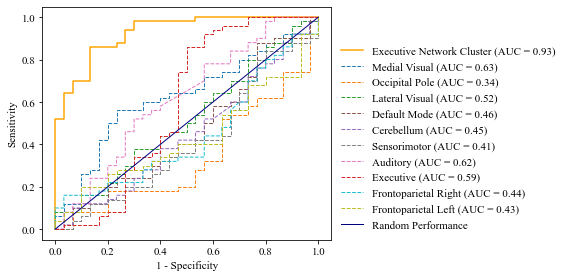

In [21]:
# Repeat for TEST data
plt.rc('font', family = 'Times New Roman', size = 11)
fig, ax = plt.subplots()

# Plot each data set
ax.plot(exn_roi_fpr_test, exn_roi_tpr_test, color = 'orange', 
        label = 'Executive Network Cluster (AUC = {})'.format(exn_roi_auc_test))
ax.plot(rsn1_fpr_test, rsn1_tpr_test, lw = 1, linestyle = '--', color = 'tab:blue', 
        label = 'Medial Visual (AUC = {})'.format(rsn1_auc_test))
ax.plot(rsn2_fpr_test, rsn2_tpr_test, lw = 1, linestyle = '--', color = 'tab:orange', 
        label = 'Occipital Pole (AUC = {})'.format(rsn2_auc_test))
ax.plot(rsn3_fpr_test, rsn3_tpr_test, lw = 1, linestyle = '--', color = 'tab:green', 
        label = 'Lateral Visual (AUC = {})'.format(rsn3_auc_test))
ax.plot(rsn4_fpr_test, rsn4_tpr_test, lw = 1, linestyle = '--', color = 'tab:brown', 
        label = 'Default Mode (AUC = {})'.format(rsn4_auc_test))
ax.plot(rsn5_fpr_test, rsn5_tpr_test, lw = 1, linestyle = '--', color = 'tab:purple', 
        label = 'Cerebellum (AUC = {})'.format(rsn5_auc_test))
ax.plot(rsn6_fpr_test, rsn6_tpr_test, lw = 1, linestyle = '--', color = 'tab:gray', 
        label = 'Sensorimotor (AUC = {})'.format(rsn6_auc_test))
ax.plot(rsn7_fpr_test, rsn7_tpr_test, lw = 1, linestyle = '--', color = 'tab:pink', 
        label = 'Auditory (AUC = {})'.format(rsn7_auc_test))
ax.plot(rsn8_fpr_test, rsn8_tpr_test, lw = 1, linestyle = '--', color = 'tab:red', 
        label = 'Executive (AUC = {})'.format(rsn8_auc_test))
ax.plot(rsn9_fpr_test, rsn9_tpr_test, lw = 1, linestyle = '--', color = 'tab:cyan', 
        label = 'Frontoparietal Right (AUC = {})'.format(rsn9_auc_test))
ax.plot(rsn10_fpr_test, rsn10_tpr_test, lw = 1, linestyle = '--', color = 'tab:olive', 
        label = 'Frontoparietal Left (AUC = {})'.format(rsn10_auc_test))

# Add random performance graph, legend, and axis titles
ax.plot([0, 1], [0, 1], color = 'navy', lw = 1, label = 'Random Performance')
ax.legend(loc = 'lower left', frameon = False, bbox_to_anchor=(1, 0))
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')

fig.tight_layout()
fig.set_size_inches(12, 4)
#plt.savefig('exn_v_rsns_test_auc_curve.png', dpi = 600)
